In [1]:
from hybrid_model import HybridModel
from hybrid_tokenizer import HybridTokenizer

import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

import datasets
from datasets import load_dataset

import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, precision_score, recall_score  

from tqdm.auto import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

### Prepare model

In [2]:
class Classifier(nn.Module):
    def __init__(self, model):
        super().__init__()
        self.model = model

        self.classifier = nn.Sequential(
            nn.Linear(256, 1),
            nn.Sigmoid()
        )

    def forward(self, **tokens):
        embeddings = self.model(**tokens)
        logits = self.classifier(embeddings)
        return logits

In [3]:
tokenizer = HybridTokenizer().from_pretrained(
    main_tokenizer_name="prajjwal1/bert-tiny",
    foreign_tokenizer_name="openai-community/gpt2"
)

model = HybridModel(dropout=0.5)
model.increase_embedding_layer(tokenizer)
tokenizer._foreign_tokenizer.pad_token = tokenizer._foreign_tokenizer.eos_token
model.enable_lora(keep_embeddings=True, verbose=True)
classifier = Classifier(model=model) 

Model trainable parameters:
trainable params: 24,576 || all params: 6,936,576 || trainable%: 0.3543
Embeddings training is enabled:
trainable params: 6,523,520 || all params: 6,936,576 || trainable%: 94.0452


### Prepare dataset

In [4]:
dataset = load_dataset("glue", "sst2")
dataset

DatasetDict({
    train: Dataset({
        features: ['sentence', 'label', 'idx'],
        num_rows: 67349
    })
    validation: Dataset({
        features: ['sentence', 'label', 'idx'],
        num_rows: 872
    })
    test: Dataset({
        features: ['sentence', 'label', 'idx'],
        num_rows: 1821
    })
})

In [5]:
def tokenize_function(examples):
  tokens = tokenizer(examples["sentence"], truncation=True, padding="max_length", max_length=100, return_tensors="pt")  
  return tokens

tokenized_dataset = dataset['train'].map(
  tokenize_function,
  batched=True,
  remove_columns=["sentence", "idx"],
) 

tokenized_dataset.set_format("pt", columns=['main_input_ids', 'foreign_input_ids', 'main_attention_mask', 'foreign_attention_mask'], output_all_columns=True)

### Training part

In [6]:
def train_one_epoch(model, dataloader, optimizer, criterion, device, tqdm_=False):
    model.train()
    total_loss = 0
    
    bar = tqdm(dataloader, desc='Training: ') if tqdm_ else dataloader
    for batch in bar:
        features, labels = batch 
        
        features = {k: v.to(device) for k, v in features.items()} 
        
        labels = labels.to(device)
        labels = labels.float()
        
        optimizer.zero_grad()
        probs = classifier(**features)
        loss = criterion(probs.reshape(-1), labels)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        
    return total_loss / len(dataloader) 

In [7]:
def inference(classifier, dataloader, criterion, device):
  predictions = []
  total_loss = 0
  total_samples = 0

  with torch.no_grad():
    for batch in dataloader:
      features, labels = batch 
      features = {k: v.to(device) for k, v in features.items()} 
      labels = labels.to(device).float()

      probs = classifier(**features).reshape(-1)
      loss = criterion(probs, labels)
      total_loss += loss.item() * labels.size(0)
      total_samples += labels.size(0)

      predictions.append(probs.cpu().numpy())

  avg_loss = total_loss / total_samples
  return np.concatenate(predictions, axis=0).reshape(-1), avg_loss

In [8]:
optim = optim.AdamW(classifier.parameters(), lr=1e-4)    
classifier = classifier.to(device)  
criterion = nn.BCELoss()    

In [9]:
train, test = tokenized_dataset.train_test_split(test_size=0.2).values()

def collate_fn(batch):
  features = {k: torch.stack([item[k] for item in batch]) for k in batch[0] if k != 'label'}
  labels = torch.tensor([item['label'] for item in batch])
  return features, labels

train_loader = DataLoader(train, batch_size=128, shuffle=True, collate_fn=collate_fn)
test_loader = DataLoader(test, batch_size=128, shuffle=False, collate_fn=collate_fn)

In [10]:
train_losses = []
test_losses = []
test_f1 = []
test_precision = []
test_recall = []

In [11]:
for ep in range(30): 
  train_loss = train_one_epoch(classifier, train_loader, optim, criterion, device, tqdm_=False)  
  
  test_predictions, test_loss = inference(classifier, test_loader, criterion, device)
  test_predictions = np.where(test_predictions > 0.5, 1, 0)
  
  precision = precision_score(test['label'], test_predictions)
  recall = recall_score(test['label'], test_predictions)
  f1 = f1_score(test['label'], test_predictions)
  
  train_losses.append(train_loss)
  test_losses.append(test_loss)
  test_f1.append(f1)
  test_precision.append(precision)
  test_recall.append(recall)
  
  print(f"Epoch {ep+1} - Train Loss: {train_loss:.4f} | Test Loss: {test_loss:.4f}")
  print(f"Epoch {ep+1} - Precision: {precision:.4f}, Recall: {recall:.4f}, F1: {f1:.4f}")

Epoch 1 - Train Loss: 0.5615 | Test Loss: 0.3797
Epoch 1 - Precision: 0.8583, Recall: 0.8485, F1: 0.8533
Epoch 2 - Train Loss: 0.3114 | Test Loss: 0.3018
Epoch 2 - Precision: 0.8896, Recall: 0.8929, F1: 0.8913
Epoch 3 - Train Loss: 0.2413 | Test Loss: 0.2773
Epoch 3 - Precision: 0.9096, Recall: 0.8937, F1: 0.9016
Epoch 4 - Train Loss: 0.2013 | Test Loss: 0.2707
Epoch 4 - Precision: 0.9231, Recall: 0.8904, F1: 0.9065
Epoch 5 - Train Loss: 0.1726 | Test Loss: 0.2645
Epoch 5 - Precision: 0.9242, Recall: 0.8978, F1: 0.9108
Epoch 6 - Train Loss: 0.1497 | Test Loss: 0.2650
Epoch 6 - Precision: 0.9165, Recall: 0.9086, F1: 0.9125
Epoch 7 - Train Loss: 0.1351 | Test Loss: 0.2730
Epoch 7 - Precision: 0.9237, Recall: 0.9007, F1: 0.9121
Epoch 8 - Train Loss: 0.1199 | Test Loss: 0.2705
Epoch 8 - Precision: 0.9270, Recall: 0.9084, F1: 0.9176
Epoch 9 - Train Loss: 0.1079 | Test Loss: 0.2731
Epoch 9 - Precision: 0.9216, Recall: 0.9153, F1: 0.9184
Epoch 10 - Train Loss: 0.0977 | Test Loss: 0.2844
Epoch

In [15]:
max(test_f1)

0.9249933386624034

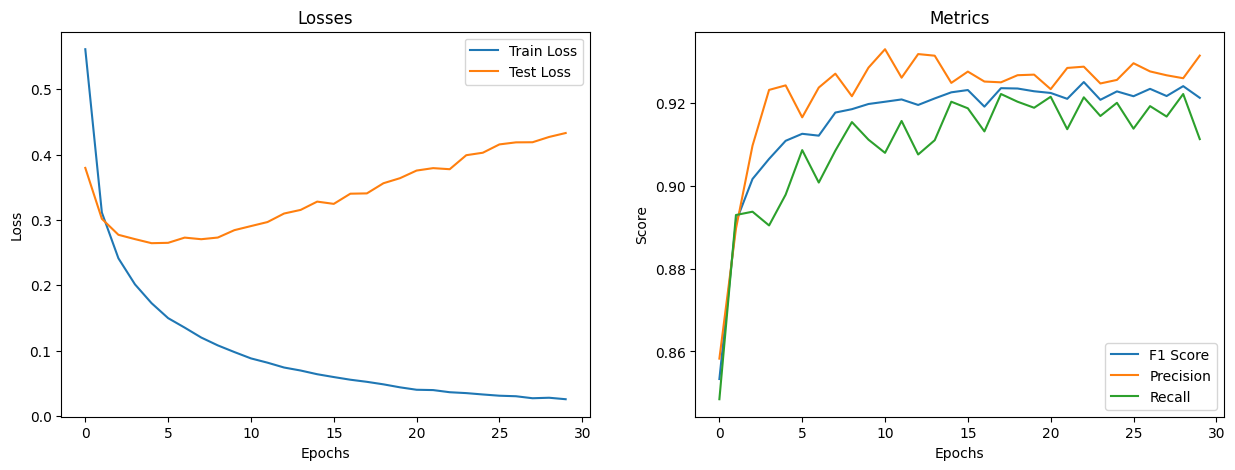

In [12]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5)) 
ax1.plot(train_losses, label='Train Loss')
ax1.plot(test_losses, label='Test Loss')
ax1.set_title('Losses')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.legend()

ax2.plot(test_f1, label='F1 Score')
ax2.plot(test_precision, label='Precision')
ax2.plot(test_recall, label='Recall')
ax2.set_title('Metrics')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Score')
ax2.legend()

In [13]:
import shap

# Take a batch from test_loader for SHAP explanation
batch = next(iter(test_loader))
features, labels = batch
features = {k: v.to(device) for k, v in features.items()}

# Get embeddings for a small sample
X_sample = {k: v[:15] for k, v in features.items()}
embeddings = classifier.model(**X_sample).detach().cpu().numpy()

# Define a prediction function for SHAP that works on embeddings
def predict_from_embeddings(emb):
    emb_tensor = torch.tensor(emb, dtype=torch.float32).to(device)
    with torch.no_grad():
        out = classifier.classifier.to(device)(emb_tensor)
    return out.cpu().numpy()

# Use KernelExplainer on the classifier's output given embeddings
explainer = shap.KernelExplainer(predict_from_embeddings, embeddings)
shap_values = explainer.shap_values(embeddings)

  0%|          | 0/15 [00:00<?, ?it/s]

<BarContainer object of 256 artists>

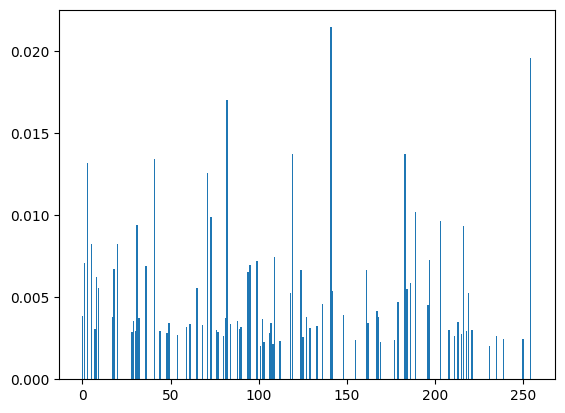

In [14]:
import numpy as np

feature_importance = np.abs(shap_values).mean(axis=0).reshape(-1)
plt.bar(list(range(256)), height=feature_importance)